In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [32]:
df = pd.read_csv("/Users/bolsolui/Library/CloudStorage/OneDrive-adidas/Documents/personal/github/forecasting_rais_data/pipeline/files/escolaridade/escolaridade.csv")
df = df[df["ano"]==2021]
df = pd.get_dummies(df, columns=["sexo"])

In [33]:

# Define salary groupings
df["salary_group"] = pd.cut(
    df["sm_code"],
    bins=[-1, 3, 7, 11],
    labels=[1, 2, 3]
)

In [34]:
df.head()

,capital,faixa_remuneracao_media_sm,Analfabeto,Até 5ª Incompleto,5ª Completo Fundamental,6ª a 9ª Fundamental,Fundamental Completo,Médio Incompleto,Médio Completo,Superior Incompleto,Superior Completo,Mestrado,Doutorado,ano,capital_code,sm_code,sexo_F,sexo_M,salary_group
7128,porto_velho,"ate_0,50",4,2,2,30,16,203,257,14,49,0,0,2021,ro,0,True,False,1
7129,porto_velho,"0,51_a_1,00",8,27,29,75,182,321,2198,168,299,5,4,2021,ro,1,True,False,1
7130,porto_velho,"1,01_a_1,50",48,134,155,357,722,852,11840,704,1413,11,1,2021,ro,2,True,False,1
7131,porto_velho,"1,51_a_2,00",11,79,79,204,350,369,5196,307,1387,18,4,2021,ro,3,True,False,1
7132,porto_velho,"2,01_a_3,00",7,331,54,156,655,98,3710,324,3757,31,14,2021,ro,4,True,False,2


In [35]:
cols_to_drop = ['Até 5ª Incompleto',
 '5ª Completo Fundamental',
 '6ª a 9ª Fundamental',
 'Fundamental Completo',
 'Médio Incompleto',
 "ano",
 "capital",
 "faixa_remuneracao_media_sm",
 "capital_code",
 "sm_code"

 ]

In [36]:
df = df.drop(columns=cols_to_drop)

In [49]:
df.columns

Index(['sexo_F', 'sexo_M', 'salary_group', 'Escolaridade_Analfabeto',
       'Escolaridade_Doutorado', 'Escolaridade_Mestrado',
       'Escolaridade_Médio Completo', 'Escolaridade_Superior Completo',
       'Escolaridade_Superior Incompleto'],
      dtype='object')

In [37]:
#transforming row data instead group - to model perform better
df_expanded = df.melt(id_vars=["sexo_F", "sexo_M", "salary_group"], 
                       var_name="Escolaridade", 
                       value_name="Quantidade")


df_expanded = df_expanded.loc[df_expanded.index.repeat(df_expanded["Quantidade"])].drop(columns=["Quantidade"])

df = pd.get_dummies(df_expanded, columns=["Escolaridade"], dtype=int)

df.reset_index(drop=True, inplace=True)


df.head()


,sexo_F,sexo_M,salary_group,Escolaridade_Analfabeto,Escolaridade_Doutorado,Escolaridade_Mestrado,Escolaridade_Médio Completo,Escolaridade_Superior Completo,Escolaridade_Superior Incompleto
0,True,False,1,1,0,0,0,0,0
1,True,False,1,1,0,0,0,0,0
2,True,False,1,1,0,0,0,0,0
3,True,False,1,1,0,0,0,0,0
4,True,False,1,1,0,0,0,0,0


In [38]:
X = df.drop(columns=["salary_group"])  
y = df["salary_group"] 

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_train.shape, X_test.shape, y_train.shape, y_test.shape


((11853492, 8), (2963373, 8), (11853492,), (2963373,))

In [39]:

model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)

model.fit(X_train, y_train)

model.coef_, model.intercept_


(array([[ 0.30308268, -0.25487313,  1.53641514, -1.48192486, -1.07394372,
          1.31447378, -0.76772846,  0.52091766],
        [ 0.16577463,  0.1310038 , -0.05295426, -0.17982122,  0.05206773,
          0.09541589,  0.17303241,  0.20903789],
        [-0.46885731,  0.12386933, -1.48346089,  1.66174607,  1.02187599,
         -1.40988967,  0.59469606, -0.72995555]]),
 array([ 0.04823062,  0.29692703, -0.34515765]))

In [40]:

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

#precision, recall, F1-score
class_report = classification_report(y_test, y_pred)

conf_matrix


array([[1165029,  200212,    3158],
       [ 535820,  628339,   11947],
       [  52535,  344531,   21802]])

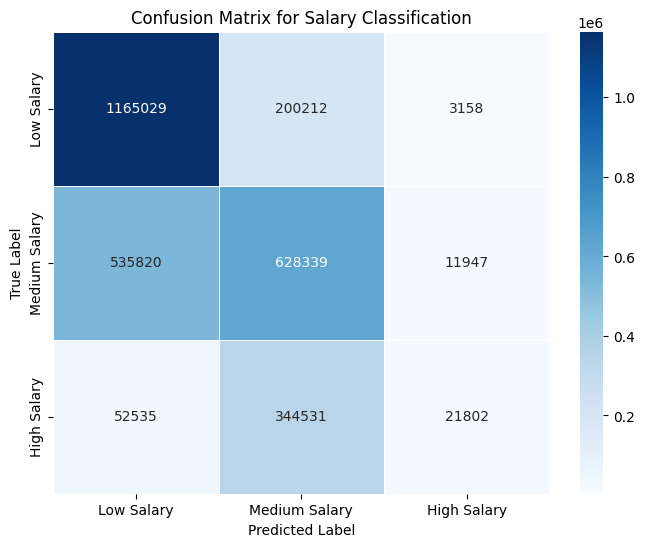

In [41]:
class_labels = ["Low Salary", "Medium Salary", "High Salary"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Salary Classification")
plt.show()


In [42]:
accuracy

0.6125351077977697

In [43]:

report_dict = classification_report(y_test, y_pred, output_dict=True)


df_report = pd.DataFrame(report_dict).T.iloc[:3, :3] 

df_report.index = ["1 (Low Salary)", "2 (Medium Salary)", "3 (High Salary)"]

df_report = df_report * 100
df_report = df_report.round(1).astype(str) + "%"
df_report


,precision,recall,f1-score
1 (Low Salary),66.4%,85.1%,74.6%
2 (Medium Salary),53.6%,53.4%,53.5%
3 (High Salary),59.1%,5.2%,9.6%


✅ Precision (Precisão) → Das previsões feitas para cada classe, quantas estavam corretas?

✅ Recall (Revocação) → De todos os valores reais dessa classe, quantos foram corretamente previstos?

✅ F1-Score → Média harmônica entre precisão e recall (equilíbrio entre os dois).

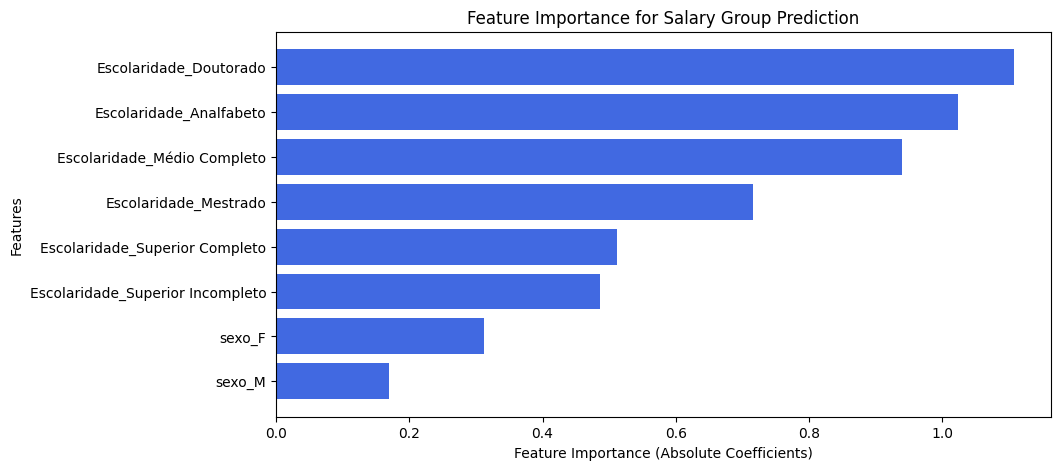

In [44]:
feature_importance = np.mean(np.abs(model.coef_), axis=0)

feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})

importance_df = importance_df.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="royalblue")
plt.xlabel("Feature Importance (Absolute Coefficients)")
plt.ylabel("Features")
plt.title("Feature Importance for Salary Group Prediction")
plt.gca().invert_yaxis()  
plt.show()


In [20]:

odds_ratios = np.exp(model.coef_)

feature_names = X_train.columns
odds_df = pd.DataFrame(odds_ratios.T, index=feature_names, columns=["Low Salary", "Medium Salary", "High Salary"])

odds_df

,Low Salary,Medium Salary,High Salary
sexo_F,1.354026,1.180307,0.625717
sexo_M,0.775015,1.139972,1.131868
Escolaridade_Analfabeto,4.647898,0.948423,0.226851
Escolaridade_Doutorado,0.227200,0.835420,5.268502
Escolaridade_Mestrado,0.341658,1.053447,2.778402
Escolaridade_Médio Completo,3.722791,1.100116,0.244170
Escolaridade_Superior Completo,0.464066,1.188905,1.812480
Escolaridade_Superior Incompleto,1.683572,1.232492,0.481930


In [45]:
#Cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

cv_mean, cv_std


(0.6126139368888087, 0.00018921251818586126)

In [46]:
#traking data
performance_data = {
    "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "accuracy": accuracy,
    "precision_low": report_dict["1"]["precision"],
    "recall_low": report_dict["1"]["recall"],
    "f1_low": report_dict["1"]["f1-score"],
    "precision_medium": report_dict["2"]["precision"],
    "recall_medium": report_dict["2"]["recall"],
    "f1_medium": report_dict["2"]["f1-score"],
    "precision_high": report_dict["3"]["precision"],
    "recall_high": report_dict["3"]["recall"],
    "f1_high": report_dict["3"]["f1-score"],
    "cv_mean_accuracy": cv_mean,
    "cv_std_accuracy": cv_std
}

df_performance = pd.DataFrame([performance_data])


csv_filename = "model_performance_log.csv"
try:
    existing_data = pd.read_csv(csv_filename)
    df_performance = pd.concat([existing_data, df_performance], ignore_index=True)
except FileNotFoundError:
    pass  

df_performance.to_csv(csv_filename, index=False)

df_performance.tail()



,timestamp,accuracy,precision_low,recall_low,f1_low,precision_medium,recall_medium,f1_medium,precision_high,recall_high,f1_high,cv_mean_accuracy,cv_std_accuracy
0,2025-02-15 23:58:54,0.612535,0.664446,0.851381,0.746387,0.535631,0.534254,0.534941,0.590728,0.05205,0.09567,0.612614,0.000189
